# Causation, Collision, and Confusion


This is one of the Jupyter notebooks I used in my preparation of *Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions*.

The book is scheduled to be published by University of Chicago Press in 2023.
If you would like to get infrequent email announcements about the book, please
[sign up for my mailing list](http://eepurl.com/h0nfbX).

Before you read these notebooks, please keep in mind:

* There is some explanatory text in the notebooks, but some of the examples will not make sense until you have read the corresponding chapter in the book.

* While preparing these notebooks, I made some changes to improve the readability of the code. There might be small differences between what appears in the book and what you get when you run the code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/birthweight.ipynb).

In [1]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate

# Set the random seed so we get the same results every time
np.random.seed(17)

The Low Birthweight Paradox was born in 1971, when Jacob Yerushalmy, a researcher at U.C. Berkeley, published "The relationship of parents' cigarette smoking to outcome of pregnancy -- implications as to the problem of inferring causation from observed associations".
As the title suggests, the paper is about the relationship between smoking during pregnancy, the weight of babies at birth, and mortality in the first month of life.

Based on data from about 13,000 babies born near San Francisco between 1960 and 1967, Yerushalmy reported that

* Babies of mothers who smoked were about 6% lighter at birth. 

* Smokers were about twice as likely to have babies lighter than 2500 grams, which is considered "low birthweight".

* Low-birthweight babies were much more likely to die within a month of birth: the mortality rate was 174 per 1000 for low-birthweight babies and 7.8 per 1000 for others.

These results were not surprising. At that time, it was well known that children of smokers were lighter at birth, and that low-birthweight babies were more likely to die.

In the first part of this notebook, there are several cells like the following that compute percentages based on numbers from tables in Yerushalmy's paper.

In [4]:
(3464 - 3255) / 3255 * 100

6.42089093701997

Putting those results together, you might expect mortality rates to be higher for children of smokers.
And you would be right, but the difference was not very big. For White mothers, the mortality rate was 11.3 per 1000 for children of smokers, compared to 11.0 for children of nonsmokers.

That's strange, but it gets even stranger. If we select only the low-birthweight (LBW) babies, we find:

* For LBW babies of nonsmokers, the mortality rate was 218 per 1000; 

* For LBW babies of smokers, it was only 114 per 1000, about 48% lower.

In [5]:
(218 - 114) / 218 * 100

47.706422018348626

Yerushalmy also compared rates of congenital anomalies (birth defects).

* For LBW babies of nonsmokers, the rate was 147 per 1000,

* For LBW babies of smokers, it was 72 per 1000, about 53% lower. 

These results make maternal smoking seem *beneficial* for low-birthweight babies, somehow protecting them from birth defects and mortality.
Yerushalmy concluded:

> These paradoxical findings raise doubts and argue against the proposition that cigarette smoking acts as an exogenous factor which interferes with intrauterine development of the fetus.

In other words, maybe maternal smoking isn't bad for babies after all.

In [6]:
(147 - 72) / 142

0.528169014084507

But it was a mistake.
At the risk of giving away the ending, the Low Birthweight Paradox is a statistical artifact.
In fact, maternal smoking is harmful to babies, regardless of birthweight.
It only seems beneficial because the analysis is misleading.

An explanation came in 2006 from epidemiologists at Harvard University and the National Institutes of Health (NIH), based on data from 3 million babies born in 1991.
Using the same dataset, which is available from the National Center for Health Statistics (NCHS), I will replicate their results and summarize their explanation.
Then I'll repeat the analysis with data from 2018, and we'll see what has changed.

## Three Million Babies Can't Be Wrong

The data are originally from the [National Center for Health Statistics (NCHS)](https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm).

I selected the columns we need and stored them in a compressed HDF file.

In [7]:
DATA_PATH = "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/"

download(DATA_PATH + "nchs.hdf")

In [8]:
vs1991 = pd.read_hdf("nchs.hdf", "vs1991")
vs1991.shape

(4115493, 5)

If age of death is NaN, that means the baby survived.

In [9]:
vs1991["mort"] = vs1991["aged"].notnull()
vs1991["mort"].value_counts()

False    4079973
True       35520
Name: mort, dtype: int64

Recode the tobacco variable.

In [10]:
vs1991["tobacco"].replace([9], np.nan, inplace=True)
vs1991["tobacco"].value_counts()

2.0    2471563
1.0     533202
Name: tobacco, dtype: int64

In [11]:
from empiricaldist import Pmf

Pmf.from_seq(vs1991["tobacco"])

,probs
1.0,0.177452
2.0,0.822548


Getting some numbers from the paper into a PMF.

In [12]:
white = np.array([6067, 3726])
black = np.array([2219, 1071])

pmf = Pmf(white + black, index=["Nonsmoker", "Smoker"])
pmf.normalize()
pmf

,probs
Nonsmoker,0.633341
Smoker,0.366659


Checking the distribution of birthweights.

<Axes: >

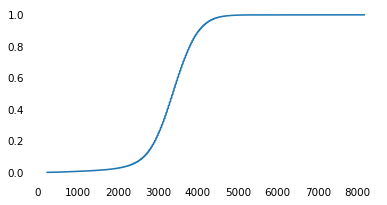

In [14]:
from empiricaldist import Cdf

vs1991["birthweight"].replace([7777, 9999], np.nan, inplace=True)
Cdf.from_seq(vs1991["birthweight"]).plot()

In [15]:
vs1991["birthweight"].nlargest(10)

1282965    8164.0
2328658    8164.0
2345800    8147.0
3078492    8108.0
1407733    7966.0
3037159    7965.0
2395933    7910.0
3046903    7890.0
2513239    7889.0
2582863    7880.0
Name: birthweight, dtype: float64

Flagging low birthweight babies.

In [16]:
vs1991["lbw"] = vs1991["birthweight"] < 2500

Dividing birthweights into bins.

In [17]:
bins = np.arange(1000, 5000, 250)
bins

array([1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500,
       3750, 4000, 4250, 4500, 4750])

In [18]:
vs1991["bin"] = pd.cut(vs1991["birthweight"], bins)
vs1991["bin"].value_counts().sort_index()

(1000, 1250]     12374
(1250, 1500]     14661
(1500, 1750]     21393
(1750, 2000]     34816
(2000, 2250]     61218
(2250, 2500]    123119
(2500, 2750]    246404
(2750, 3000]    426903
(3000, 3250]    696739
(3250, 3500]    817652
(3500, 3750]    712945
(3750, 4000]    482449
(4000, 4250]    240867
(4250, 4500]    122762
(4500, 4750]     46395
Name: bin, dtype: int64

Checking the codes for congenital birth defects.

In [19]:
vs1991["congenit"].value_counts()

2222222222222222222222    3556241
9999999999999999999999     498038
2222222222222222222221      23448
2222222222222222221222       5843
2222221222222222222222       3771
                           ...   
2222211112112122221222          1
2222121222122222222222          1
2212122222221221222222          1
2222222122222211222222          1
2222122222122222122222          1
Name: congenit, Length: 1008, dtype: int64

Each code is a vector that indicates the presence or absence of a particular condition. All 2's means no anomalies. 

In [20]:
vs1991["anomaly"] = vs1991["congenit"] != "2222222222222222222222"
vs1991["anomaly"].value_counts()

False    3556241
True      559252
Name: anomaly, dtype: int64

In [21]:
no_defect = vs1991["congenit"] == "2222222222222222222222"
no_defect.sum()

3556241

In [22]:
unknown = vs1991["congenit"] == "9999999999999999999999"
vs1991.loc[unknown, "anomaly"] = np.nan
unknown.sum()

498038

In [23]:
known_defect = (~no_defect) & (~unknown)
known_defect.sum()

61214

If we select cases with known tobacco use and birthweight, we're down to about three million live births.

In [24]:
subset = vs1991.dropna(subset=["tobacco", "birthweight"])
subset.shape

(3001607, 9)

In [25]:
for name, group in subset.groupby("tobacco"):
    print(name, group["anomaly"].mean() * 1000)

1.0 20.599922088040515
2.0 18.1934659988842


In [26]:
def percent_diff(x, rel):
    """Percentage difference.

    x: the number of interest
    rel: the number it is relative to

    returns: float percent
    """
    return (x - rel) / rel * 100

In [27]:
percent_diff(20.6, 18.2)

13.186813186813199

In [28]:
subset_no_defect = subset[subset["anomaly"] == 0]
subset_no_defect.shape

(2816996, 9)

In [29]:
weights = subset.groupby("tobacco")["birthweight"].mean()
weights

tobacco
1.0    3145.189278
2.0    3370.030102
Name: birthweight, dtype: float64

In [30]:
percent_diff(3145, 3370)

-6.6765578635014835

In the 1991 data from NCHS, about 18% of the mothers reported smoking during pregnancy, down from 37% in Yerushalmy's dataset from the 1960s.
Babies of smokers were lighter on average than babies of nonsmokers by about 7%, which is comparable to the difference in the 1960s data.

The following figure shows the distribution of weights for the two groups. The vertical line is at 2500 grams, the threshold for low birthweight.

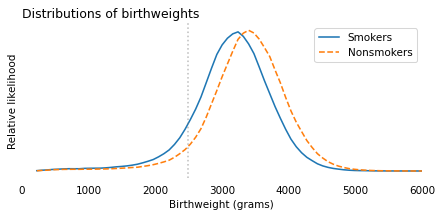

In [31]:
from utils import kdeplot

labels = {1: "Smokers", 2: "Nonsmokers"}
ls = {1: "-", 2: "--"}

xs = np.linspace(subset["birthweight"].min(), subset["birthweight"].max(), 101)
for name, group in subset.groupby("tobacco"):
    kdeplot(group["birthweight"], xs, label=labels[name], ls=ls[name])

plt.axvline(2500, color="gray", ls=":", alpha=0.5)
decorate(
    xlabel="Birthweight (grams)",
    ylabel="Relative likelihood",
    title="Distributions of birthweights",
    xlim=[0, 6000],
)

The shapes of the distributions are similar, but for smokers it is shifted to the left.
For mothers who smoked, the fraction of babies below 2500 grams is about 11%; for nonsmokers it is only 6%.

In [32]:
subset["lbw"].mean()

0.07262476400141657

In [33]:
for name, group in subset.groupby("tobacco"):
    lbw_rate = group["lbw"].mean()
    print(name, lbw_rate)

1.0 0.11421285960264155
2.0 0.06365429478663773


In [34]:
percent_diff(11.4, 6.4)

78.125

In [35]:
(9793 * 11.1 + 3290 * 18.5) / (9793 + 3290)

12.960888175494917

In [36]:
subset["mort"].mean() * 1000

8.449473898481713

Overall infant mortality was substantially lower in 1991. 
In the 1960s dataset, about 13 per 1000 babies died within the first *month* of life; in 1991, about 8.5 per 1000 died in the first *year*.   

In 1991, the mortality rate was higher for babies of smokers, almost 12 per 1000, than babies of nonsmokers, 7.7 per 1000.
So the risk of mortality was 54% higher for babies of mothers who smoked.

In [37]:
for name, group in subset.groupby("tobacco"):
    rate = group["mort"].mean() * 1000
    print(name, rate)

1.0 11.874562261649707
2.0 7.71068917473998


In [38]:
percent_diff(1187, 771)

53.95590142671855

In summary, babies of mothers who smoked were about twice as likely to be underweight, and underweight babies were about 50% more likely to die.
However, if we select babies lighter than 2500 grams, the mortality rate is 20% *lower* for babies of smokers, compared to LBW babies of nonsmokers.

In [39]:
for name, group in subset[subset["lbw"]].groupby("tobacco"):
    rate = group["mort"].mean() * 1000
    print(name, rate)

1.0 60.138756452832666
2.0 74.8512709572742


In [40]:
percent_diff(60.1, 74.85)

-19.70607882431529

The analysis so far is based on only two groups, babies born lighter or heavier than 2500 grams.
But it might be a mistake to lump all LBW babies together.
In reality, a baby born close to 2500 grams has a better chance of surviving than a baby born at 1500 grams.

So, following the analysis in the 2006 paper, I partitioned the dataset into groups with similar birthweight and computed the mortality rate in each group.
The following figure shows the results.

In [41]:
table = pd.pivot_table(subset, index="bin", columns="tobacco", values="mort")
table *= 1000
table.index = bins[:-1] + np.diff(bins) / 2
table

tobacco,1.0,2.0
1125.0,102.376600,106.864725
1375.0,65.099458,72.467402
1625.0,43.963878,48.194837
1875.0,31.085935,32.530380
2125.0,22.160247,20.968439
2375.0,16.087278,13.399794
2625.0,9.483955,7.970344
2875.0,7.015749,4.987658
3125.0,5.610098,3.629459
3375.0,5.005695,2.534403


In [42]:
def plot_table(table, title):
    table[1].plot(label="Smoker")
    table[2].plot(ls="--", label="Nonsmoker")

    decorate(
        xlabel="Birth weight (grams)",
        ylabel="Mortality rate per 1000",
        title=title,
    )

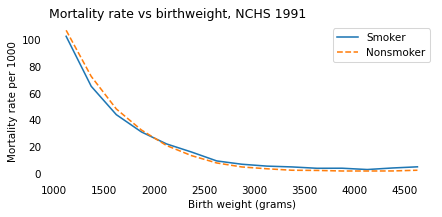

In [43]:
plot_table(table, "Mortality rate vs birthweight, NCHS 1991")

This figure provides a more detailed view of the Low Birthweight Paradox.
Among babies heavier than 2000 grams, mortality is higher for children of smokers, as expected.
Among lighter babies, mortality is lower for children of smokers.

## Other Groups

As it turns out, the Low Birthweight Paradox doesn't apply only to smokers and nonsmokers.
The 2006 paper describe a similar effect for babies born at high altitude: they are lighter on average than babies born at low altitude, but if we select LBW babies, the mortality rate is lower for the ones born at high altitude.

And Yerushalmy reported another example. 
Babies of short mothers are lighter, on average, than babies of tall mothers. In his dataset, babies of short mothers were twice as likely to be LBW, but among LBW babies of short mothers, the mortality rate was 49% lower and the rate of birth defects was 34% lower.

Yerushalmy called the relationship between smokers and nonsmokers, and between short and tall mothers, a "remarkable parallelism". 
But he did not recognize it as evidence that statistical bias is the explanation for both.
Instead, he doubled down:

> This comparison is presented not as proof that the differences between smokers and nonsmokers are necessarily of biological origin, rather it is to indicate that a biological hypothesis is not unreasonable.

With the benefit of further research, we can see that Yerushalmy was mistaken. Smoking, high altitude, and short mothers do not protect low-birthweight babies from birth defects and mortality. Rather, they provide a relatively benign explanation for low birthweight.

In [44]:
percent_diff(110, 214)

-48.598130841121495

In [45]:
percent_diff(96, 146)

-34.24657534246575

To see why, suppose four things can cause low birthweight:

* The mother might be short, which is not at all harmful to the baby.

* The baby might be born at high altitude, which has little if any effect on mortality.

* The mother might be a smoker, which is somewhat harmful to the baby, or

* The baby might have a birth defect, which greatly increases the rate of mortality.

Now suppose you are a doctor and you hear that a baby under your care was born underweight.
You would be concerned, because you know that the baby faces a higher than average risk of mortality.

But suppose the baby was born in Santa Fe, New Mexico, at 2200 meters of elevation to a mother at only 150 cm of elevation (just under five feet).
You would be relieved, because either of those factors might explain low birthweight, and neither implies a substantial increase in mortality.

And if you learned that the mother was a smoker, that would be good news, too, because it provides another possible explanation for low birthweight, which means that the last and most harmful explanation is less likely.
Maternal smoking is still bad for babies, but it is not as bad as birth defects.

It is frustrating that Yerushalmy did not discover this explanation.
In retrospect, he had all the evidence he needed, including the smoking gun (sorry!): the rates of birth defects.

We've seen that LBW babies of smokers are less likely to have birth defects, but that's not because maternal smoking somehow protects babies from congenital anomalies.
It's because low birthweight generally has a cause, and if the cause is not smoking, it is more likely to be something else, including a birth defect.

We can confirm that this explanation is correct by selecting babies with no congenital anomalies observed at birth.
If we do that, we find that babies of smokers have higher mortality rates in nearly every weight category, as expected.

In [46]:
lbw = (subset_no_defect["birthweight"] > 1000) & (
    subset_no_defect["birthweight"] < 2500
)

In [47]:
rate = subset_no_defect[lbw].groupby("tobacco")["mort"].mean() * 1000
rate

tobacco
1.0    21.316747
2.0    19.730921
Name: mort, dtype: float64

In [48]:
percent_diff(*rate)

8.037265001800348

In [49]:
table = pd.pivot_table(subset_no_defect, index="bin", columns="tobacco", values="mort")
table *= 1000
table.index = bins[:-1] + np.diff(bins) / 2
table

tobacco,1.0,2.0
1125.0,90.295797,88.376720
1375.0,50.944947,54.970094
1625.0,30.974633,32.201915
1875.0,24.103738,21.577559
2125.0,17.170891,13.721836
2375.0,12.980332,8.864062
2625.0,8.139342,5.766043
2875.0,6.234500,3.911355
3125.0,5.139620,2.867080
3375.0,4.480155,2.117150


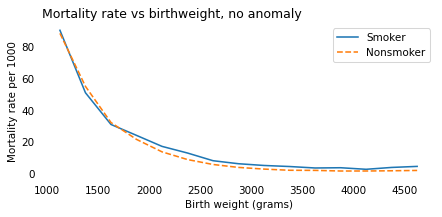

In [50]:
plot_table(table, "Mortality rate vs birthweight, no anomaly")

## The End of the Paradox

In the most recent NCHS dataset, including 3.8 million babies born in 2018, the Low Birthweight Paradox has disappeared.

In [51]:
vs2018 = pd.read_hdf("nchs.hdf", "vs2018")

In [52]:
vs2018.shape

(3801533, 3)

In [53]:
vs2018["yod"].value_counts(dropna=False)

NaN       3780154
2018.0      18735
2019.0       2644
Name: yod, dtype: int64

In [54]:
vs2018["mort"] = vs2018["yod"].notnull()
vs2018["mort"].value_counts()

False    3780154
True       21379
Name: mort, dtype: int64

In [55]:
vs2018["tobacco"].value_counts()

N    3539051
Y     245360
U      17122
Name: tobacco, dtype: int64

In [56]:
vs2018["tobacco"].replace(["U"], np.nan, inplace=True)
vs2018["tobacco"].value_counts(dropna=False)

N      3539051
Y       245360
NaN      17122
Name: tobacco, dtype: int64

In [57]:
from empiricaldist import Pmf

Pmf.from_seq(vs2018["tobacco"])

,probs
N,0.935166
Y,0.064834


In this dataset, only 6% of the mothers reported smoking during pregnancy, down from 18% in 1991 and 37% in the 1960s.

In [58]:
vs2018["birthweight"].value_counts().sort_index()

227      157
228        5
229        7
230       34
231        4
        ... 
8025       1
8160       1
8161       1
8165      12
9999    2100
Name: birthweight, Length: 5357, dtype: int64

<Axes: >

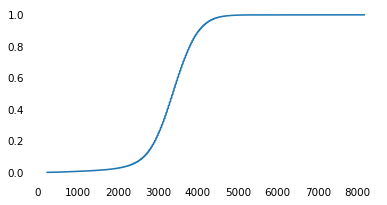

In [59]:
vs1991["birthweight"].replace([7777, 8165, 9999], np.nan, inplace=True)
Cdf.from_seq(vs1991["birthweight"]).plot()

In [60]:
vs2018["birthweight"].nlargest(10)

154      9999
4980     9999
7444     9999
8105     9999
9959     9999
21426    9999
21894    9999
39015    9999
41443    9999
44339    9999
Name: birthweight, dtype: int64

In [61]:
vs2018["lbw"] = vs2018["birthweight"] < 2500

In [62]:
bins = np.arange(1000, 5000, 250)
bins

array([1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500,
       3750, 4000, 4250, 4500, 4750])

In [63]:
vs2018["bin"] = pd.cut(vs2018["birthweight"], bins)
vs2018["bin"].value_counts().sort_index()

(1000, 1250]     12263
(1250, 1500]     15841
(1500, 1750]     23552
(1750, 2000]     38581
(2000, 2250]     69739
(2250, 2500]    132815
(2500, 2750]    258005
(2750, 3000]    460541
(3000, 3250]    702121
(3250, 3500]    772754
(3500, 3750]    617937
(3750, 4000]    379535
(4000, 4250]    176360
(4250, 4500]     75196
(4500, 4750]     26293
Name: bin, dtype: int64

In [64]:
subset = vs2018.dropna(subset=["tobacco", "birthweight"])
subset.shape

(3784411, 6)

In [65]:
weights = subset.groupby("tobacco")["birthweight"].mean()
weights

tobacco
N    3278.574154
Y    3071.500656
Name: birthweight, dtype: float64

In [66]:
percent_diff(3067, 3275)

-6.35114503816794

Babies of smokers were lighter on average than babies of nonsmokers by about 6%, comparable to the difference in the previous two datasets.

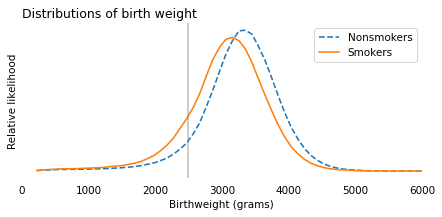

In [67]:
labels = {"Y": "Smokers", "N": "Nonsmokers"}
ls = {"Y": "-", "N": "--"}

xs = np.linspace(subset["birthweight"].min(), subset["birthweight"].max(), 101)
for name, group in subset.groupby("tobacco"):
    kdeplot(group["birthweight"], xs, label=labels[name], ls=ls[name])

plt.axvline(2500, color="gray", alpha=0.5)
decorate(
    xlabel="Birthweight (grams)",
    ylabel="Relative likelihood",
    title="Distributions of birth weight",
    xlim=[0, 6000],
)

In [68]:
subset["lbw"].mean()

0.08266834654058453

In [69]:
for name, group in subset.groupby("tobacco"):
    lbw_rate = group["lbw"].mean()
    print(name, lbw_rate)

N 0.07843317318682325
Y 0.14375611346592762


In [70]:
percent_diff(14.38, 7.84)

83.4183673469388

In 2018, fewer babies died in the first year of life;
the mortality rate was 5.5 per 1000, down from 8.5 in 1991.
And the mortality rate for babies of smokers was more than twice the rate for babies of nonsmokers, almost 11 per 1000 compared to 5.1.

In [71]:
subset["mort"].mean() * 1000

5.5596498371873455

In [72]:
for name, group in subset.groupby("tobacco"):
    rate = group["mort"].mean() * 1000
    print(name, rate)

N 5.196873399111796
Y 10.792305184219106


In [73]:
percent_diff(10.72, 5.16)

107.75193798449614

In [74]:
for name, group in subset[subset["lbw"]].groupby("tobacco"):
    rate = group["mort"].mean() * 1000
    print(name, rate)

N 45.07905857431578
Y 43.20707643456566


In [75]:
percent_diff(60.1, 74.85)

-19.70607882431529

Again, we can partition the dataset into groups with similar birthweight and compute the mortality rate in each group.
The following figure shows the results.

In [76]:
table = pd.pivot_table(subset, index="bin", columns="tobacco", values="mort")
table *= 1000
table.index = bins[:-1] + np.diff(bins) / 2
table

tobacco,N,Y
1125.0,59.384364,67.014795
1375.0,40.366712,46.951220
1625.0,31.345859,36.663981
1875.0,19.119896,25.081282
2125.0,12.202122,16.664654
2375.0,6.994627,12.336111
2625.0,3.954523,9.317009
2875.0,2.652722,6.695117
3125.0,1.772246,4.676507
3375.0,1.385945,4.235809


In [77]:
def plot_table(table, title):
    table["Y"].plot(label="Smoker")
    table["N"].plot(ls="--", label="Nonsmoker")

    decorate(
        xlabel="Birth weight (grams)", ylabel="Mortality rate per 1000", title=title
    )

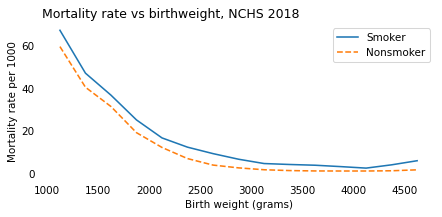

In [78]:
plot_table(table, "Mortality rate vs birthweight, NCHS 2018")

At every birthweight, mortality is higher for children of smokers.


## Causal diagrams

The 2006 paper explaining the Low Birthweight Paradox and the 2013 paper explaining the Obesity Paradox are noteworthy because they use causal diagrams to represent hypothetical causes and their effects.
For example, here is a causal diagram that represents an explanation for the Low Birthweight Paradox:

In [79]:
# based on https://matplotlib.org/matplotblog/posts/mpl-for-making-diagrams/


def make_diagram(fig_width=6, fig_height=2, bg_color="white"):
    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = fig.add_axes((0, 0, 1, 1))
    ax.set_xlim(0, fig_width)
    ax.set_ylim(0, fig_height)
    ax.set_facecolor(bg_color)

    ax.tick_params(bottom=False, top=False, left=False, right=False)
    ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    return fig, ax

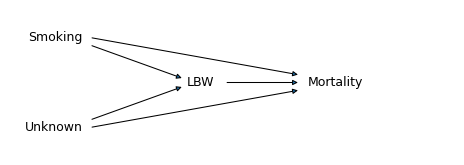

In [80]:
fig, ax = make_diagram()

# add rectangle to plot
# ax.add_patch(Rectangle((1, 1), 2, 1))

options = dict(fontsize=12, va="center")
y = 1
plt.text(1, y + 0.6, "Smoking", ha="right", **options)
plt.text(1, y - 0.6, "Unknown", ha="right", **options)
plt.text(2.75, y, "LBW", ha="right", **options)
plt.text(4, y, "Mortality", ha="left", **options)

arrowprops = dict(arrowstyle="<|-")
plt.annotate("", [1.1, y + 0.5], [2.35, y + 0.05], arrowprops=arrowprops)
plt.annotate("", [1.1, y - 0.5], [2.35, y - 0.05], arrowprops=arrowprops)
plt.annotate("", [2.9, y], [3.9, y], arrowprops=arrowprops)
plt.annotate("", [1.1, y + 0.6], [3.9, y + 0.1], arrowprops=arrowprops)
plt.annotate("", [1.1, y - 0.6], [3.9, y - 0.1], arrowprops=arrowprops)
None

The following causal diagram represents the explanation of the Obesity Paradox proposed in the 2013 paper:

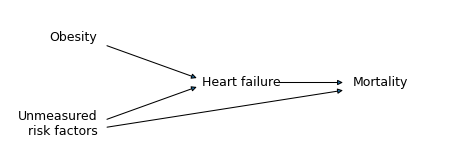

In [81]:
fig, ax = make_diagram()

options = dict(fontsize=12, va="center")
y = 1
plt.text(1.2, y + 0.6, "Obesity", ha="right", **options)
plt.text(1.2, y - 0.55, "Unmeasured\nrisk factors", ha="right", **options)
plt.text(2.6, y, "Heart failure", ha="left", **options)
plt.text(4.6, y, "Mortality", ha="left", **options)

arrowprops = dict(arrowstyle="<|-")
plt.annotate("", [1.3, y + 0.5], [2.55, y + 0.05], arrowprops=arrowprops)
plt.annotate("", [1.3, y - 0.5], [2.55, y - 0.05], arrowprops=arrowprops)
plt.annotate("", [3.6, y], [4.5, y], arrowprops=arrowprops)
plt.annotate("", [1.3, y - 0.6], [4.5, y - 0.1], arrowprops=arrowprops)
None

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).